# CIC-IDS 2017 Dataset Overview

The **CIC-IDS 2017** dataset was developed by the Canadian Institute for Cybersecurity to reflect real-world network traffic and cyberattacks. It includes diverse attack types (e.g., DoS, DDoS, Botnet, Brute Force, Infiltration) alongside normal activity, generated over multiple days.

Each row in the dataset represents a single bidirectional network flow, and each column represents a flow-level feature.

## Dataset Columns and Descriptions

| Column Name | Description |
|-------------|-------------|
| `Flow ID` | Unique identifier of a flow based on the 5-tuple (Src IP, Src Port, Dst IP, Dst Port, Protocol). |
| `Source IP` | IP address of the source machine. |
| `Source Port` | Port number used by the source machine. |
| `Destination IP` | IP address of the destination machine. |
| `Destination Port` | Port number used by the destination machine. |
| `Protocol` | Transport layer protocol used (e.g., TCP = 6, UDP = 17, ICMP = 1). |
| `Timestamp` | Time at which the flow started. |
| `Flow Duration` | Duration of the flow in microseconds. |
| `Total Fwd Packets` | Number of packets sent in the forward direction (source to destination). |
| `Total Backward Packets` | Number of packets sent in the reverse direction (destination to source). |
| `Total Length of Fwd Packets` | Sum of packet sizes in the forward direction. |
| `Total Length of Bwd Packets` | Sum of packet sizes in the backward direction. |
| `Fwd Packet Length Max/Min/Mean/Std` | Statistics on forward packet lengths. |
| `Bwd Packet Length Max/Min/Mean/Std` | Statistics on backward packet lengths. |
| `Flow Bytes/s` | Number of bytes transferred per second during the flow. |
| `Flow Packets/s` | Number of packets transferred per second during the flow. |
| `Flow IAT Mean/Std/Max/Min` | Inter-arrival time statistics between packets in the entire flow. |
| `Fwd IAT Total/Mean/Std/Max/Min` | Inter-arrival time statistics for forward direction only. |
| `Bwd IAT Total/Mean/Std/Max/Min` | Inter-arrival time statistics for backward direction only. |
| `Fwd/Bwd PSH Flags` | Count of PSH flags in forward/backward direction. |
| `Fwd/Bwd URG Flags` | Count of URG flags in forward/backward direction. |
| `Fwd/Bwd Header Length` | Total length of headers in forward/backward direction. |
| `Fwd/Bwd Packets/s` | Packet rate in each direction. |
| `Min/Max/Mean/Std/Variance Packet Length` | Packet size statistics for the entire flow. |
| `FIN/SYN/RST/PSH/ACK/URG/CWE/ECE Flag Count` | Count of each TCP flag observed in the flow. |
| `Down/Up Ratio` | Ratio of bytes sent from destination to source vs. source to destination. |
| `Average Packet Size` | Average size of all packets in the flow. |
| `Avg Fwd/Bwd Segment Size` | Average size of segments in each direction. |
| `Fwd Header Length.1` | Duplicate of forward header length. |
| `Fwd/Bwd Avg Bytes/Bulk` | Average bytes sent in bulk in each direction. |
| `Fwd/Bwd Avg Packets/Bulk` | Average packets in bulk in each direction. |
| `Fwd/Bwd Avg Bulk Rate` | Bulk transfer rate in each direction. |
| `Subflow Fwd/Bwd Packets/Bytes` | Number and size of subflows per direction. |
| `Init_Win_bytes_forward/backward` | Initial TCP window size in each direction. |
| `act_data_pkt_fwd` | Number of packets with actual data sent in forward direction. |
| `min_seg_size_forward` | Minimum segment size observed in the forward flow. |
| `Active Mean/Std/Max/Min` | Statistics of the time the flow was active. |
| `Idle Mean/Std/Max/Min` | Statistics of the time the flow was idle. |
| `Label` | String label: e.g., "BENIGN", "DDoS", "PortScan", etc. |
| `y_true` | Binary label: 0 for benign, 1 for attack. |
| `Payload` | Textual representation or synthetic payload derived from flow metadata. |

## Notes
- Some columns may contain NaNs or infinite values which should be handled during preprocessing.
- For multimodal learning, both tabular features and textual payloads can be utilized.


# Multimodal AI Model for Intrusion Detection (CIC-IDS 2017) - binary Benign (0) and Attack (1) and Multi classclassifier

## Model Description

This model is a **multimodal binary classifier** designed to detect cyberattacks using both tabular network flow features and textual payload data.

It combines two input streams:

1. **Tabular Input (Structured Features)**  
   - A dense feed-forward neural network (MLP) processes numerical and statistical features extracted from network traffic (e.g., packet lengths, flow duration, flag counts).
   - Layers include batch normalization and dropout to prevent overfitting.

2. **Text Input (Payload as Text)**  
   - Payloads from the flow are treated as raw text and passed through a pre-trained **text vectorization** layer (e.g., TF-IDF or embedding).
   - The output is then passed through dense layers for representation learning.

3. **Fusion Layer**  
   - The outputs from both branches are concatenated and passed through fully connected layers to learn the joint representation.

4. **Output Layer**  
   - A single sigmoid neuron predicts the probability of a flow being an attack (label = 1) or benign (label = 0).

The model is compiled with:
- **Loss**: Binary cross-entropy
- **Optimizer**: Adam
- **Metrics**: Accuracy and AUC

## Class Labels

The model is trained on **two classes**:

- `Benign (0)`  
  - Legitimate and non-malicious traffic.
  - Examples include regular user browsing, file transfers, and email.

- `Attack (1)`  
  - Any malicious behavior that poses a security threat.
  - This includes a mix of attack types such as DDoS, brute force, infiltration, port scanning, botnets, and more.

The label `y_true` is used to represent these classes numerically:
- `0` = Benign
- `1` = Attack

## Purpose

By combining flow-based statistics and textual patterns from the payload, this architecture aims to capture both surface-level and semantic cues associated with cyberattacks, leading to improved detection accuracy.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, zipfile, glob, gc
import pandas as pd
import numpy as np

In [7]:

DATA_DIR = "/content/generated_flows"
CACHE_DIR = "/content/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

print("Step 0: Load CSVs (or from cache)")
if not os.path.exists(os.path.join(CACHE_DIR, "df_cleaned.csv")):
    zip_path = "/content/drive/MyDrive/phd/cyb/GeneratedLabelledFlows.zip"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

    csv_files = glob.glob(os.path.join(DATA_DIR, "**", "*.csv"), recursive=True)
    df_list = []
    for file in csv_files:
        try:
            temp_df = pd.read_csv(file, encoding='utf-8', low_memory=False)
        except:
            try:
                temp_df = pd.read_csv(file, encoding='ISO-8859-1', low_memory=False)
            except:
                continue
        possible_labels = [col for col in temp_df.columns if 'label' in col.lower()]
        if possible_labels:
            temp_df.rename(columns={possible_labels[0]: 'Label'}, inplace=True)
            df_list.append(temp_df)

    df = pd.concat(df_list, ignore_index=True)
    df = df.sample(n=827876, random_state=42)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df = df[df['Label'].notnull()]
    df['Label'] = df['Label'].astype(str)
    df['y_true'] = df['Label'].apply(lambda x: 0 if 'BENIGN' in x.upper() else 1)
    df.to_csv(os.path.join(CACHE_DIR, "df_cleaned.csv"), index=False)
    del df_list
    gc.collect()
else:
    df = pd.read_csv(os.path.join(CACHE_DIR, "df_cleaned.csv"))

print("Loaded df:", df.shape)

Step 0: Load CSVs (or from cache)
Loaded df: (750588, 86)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      5,184 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 32)   │     64,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ embedding_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      1,056 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      4,160 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,545 (299.00 KB)

 Trainable params: 76,545 (299.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 52s 7ms/step - accuracy: 0.9389 - auc: 0.9664 - loss: 0.1520 - val_accuracy: 0.9725 - val_auc: 0.9957 - val_loss: 0.0624
Epoch 2/5
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9691 - auc: 0.9944 - loss: 0.0709 - val_accuracy: 0.9749 - val_auc: 0.9964 - val_loss: 0.0571
Epoch 3/5
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9722 - auc: 0.9956 - loss: 0.0620 - val_accuracy: 0.9763 - val_auc: 0.9974 - val_loss: 0.0528
Epoch 4/5
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9734 - auc: 0.9961 - loss: 0.0603 - val_accuracy: 0.9783 - val_auc: 0.9976 - val_loss: 0.0505
Epoch 5/5
1877/1877 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9745 - auc: 0.9965 - loss: 0.0560 - val_accuracy: 0.9790 - val_auc: 0.9976 - val_loss: 0.0502
4691/4691 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9799 - auc: 0.9979 - loss: 0.0454
Test Loss, Accuracy, AUC: [0.04600651562213898, 0.9795212745666504, 0.9977784156799316]


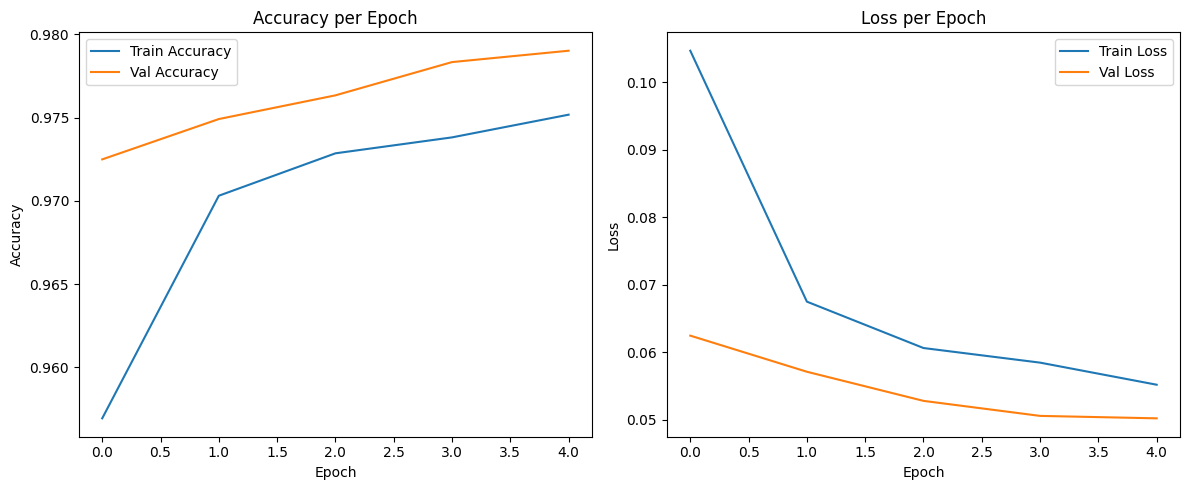

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

def make_payload(row):
    flags = []
    if row[' SYN Flag Count'] > 0: flags.append("SYN")
    if row[' ACK Flag Count'] > 0: flags.append("ACK")
    if row[' PSH Flag Count'] > 0: flags.append("PSH")

    return f"SRC={row[' Source IP']} SPORT={row[' Source Port']} " \
           f"DST={row[' Destination IP']} DPORT={row[' Destination Port']} " \
           f"PROTO={row[' Protocol']} FLAGS={','.join(flags)} " \
           f"DURATION={row[' Flow Duration']} PACKETS={row[' Total Fwd Packets']} " \
           f"LEN={row[' Total Length of Fwd Packets']}"


# Step 1: Simulate Payload if missing
if 'Payload' not in df.columns:
    df['Payload'] = df.apply(make_payload, axis=1)


# Step 2: Prepare features
excluded_cols = ['Label', 'y_true', 'Payload', 'Flow ID', 'Protocol']
tabular_cols = df.select_dtypes(include=[np.number]).columns.difference(excluded_cols).tolist()
text_col = 'Payload'

scaler = StandardScaler()
X_tab = scaler.fit_transform(df[tabular_cols])

text_vec = layers.TextVectorization(max_tokens=2000, output_mode='int', output_sequence_length=100)
text_vec.adapt(df[text_col])
X_text = text_vec(df[text_col].values)

y = df['y_true'].values

X_tab_train, X_tab_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_tab, X_text.numpy(), y, test_size=0.2, random_state=42
)

# Step 3: Build model
tabular_input = Input(shape=(X_tab.shape[1],), name='tabular_input')
x_tab = layers.Dense(64, activation='relu')(tabular_input)
x_tab = layers.Dropout(0.3)(x_tab)
x_tab = layers.Dense(32, activation='relu')(x_tab)

text_input = Input(shape=(100,), dtype='int32', name='text_input')
x_text = layers.Embedding(input_dim=2000, output_dim=32)(text_input)
x_text = layers.GlobalAveragePooling1D()(x_text)
x_text = layers.Dense(32, activation='relu')(x_text)

x = layers.concatenate([x_tab, x_text])
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=[tabular_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

# Step 4: Train
history = model.fit(
    {'tabular_input': X_tab_train, 'text_input': X_text_train},
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=256
)

# Step 5: Evaluate
results = model.evaluate({'tabular_input': X_tab_test, 'text_input': X_text_test}, y_test)
print("Test Loss, Accuracy, AUC:", results)

# Step 6: Plot training metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# Full Evaluation Block for Multimodal Cyber AI Model

### What We Get:

* **AUC score** on test set
* **ROC curve** for binary classification
* **Confusion matrix**
* **Precision / Recall / F1-score per class**


Evaluating model on test set...
4691/4691 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step

AUC on Test Set: 0.9980


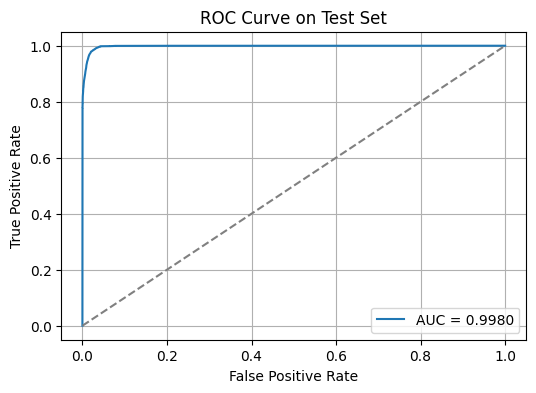

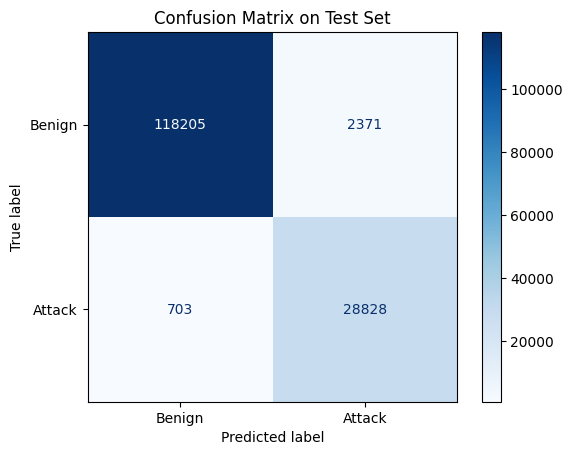


Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.98      0.99    120576
      Attack       0.92      0.98      0.95     29531

    accuracy                           0.98    150107
   macro avg       0.96      0.98      0.97    150107
weighted avg       0.98      0.98      0.98    150107



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Predict on test set ---
print("Evaluating model on test set...")
y_pred_proba = model.predict({'tabular_input': X_tab_test, 'text_input': X_text_test})
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# --- AUC Score ---
auc_test = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC on Test Set: {auc_test:.4f}")

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend()
plt.grid(True)
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Attack"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Attack"]))


# Multi class training

Certainly. Below is an **English explanation** of what the full code does, written in **plain Markdown**, with **no emojis or icons**, suitable for copy-pasting into a Colab notebook or README.

---

## Explanation of the Code

This script builds and evaluates a **multimodal classification model** for cyberattack detection using the CIC-IDS 2017 dataset. The model integrates **numerical tabular features** with **generated textual payloads** and is trained to classify multiple attack types.

---

### Step-by-step Breakdown

### Step 0: Load and Clean Data

* The dataset is loaded into a Pandas DataFrame.
* Leading and trailing spaces are removed from all column names using `df.columns.str.strip()` to ensure consistent access.

### Step 1: Generate Artificial Payload Text

* If the column `Payload` is missing, the script constructs it using selected fields such as:

  * Source/Destination IP and Port
  * Protocol
  * TCP Flags (SYN, ACK, PSH)
  * Flow duration, forward packet count, and forward length
* This payload becomes a textual representation of the network flow, used as input to the NLP part of the model.

### Step 2: Encode Attack Labels

* The `Label` column, which holds attack categories, is encoded to integer class IDs using `LabelEncoder`.
* A new column `y_class` is added to hold these numeric class values.

### Step 3: Train-Test Split

* The data is split into training and testing sets using `train_test_split`, with stratification based on the class labels.
* Inputs are split into:

  * `X_tab_train`, `X_tab_test`: Numerical/tabular features
  * `X_txt_train`, `X_txt_test`: Textual payloads
  * `y_train`, `y_test`: Integer-encoded labels

### Step 4: Text Vectorization

* A `TextVectorization` layer is created to transform the textual payloads into TF-IDF vectors.
* The vectorizer is trained on the training payloads.

### Step 5: Build a Multimodal Model

* A TensorFlow Keras model is built with two branches:

  1. A tabular branch for numerical input, with dense layers and dropout.
  2. A text branch that processes string payloads through the TF-IDF vectorizer and dense layers.
* The two branches are concatenated and fed into a dense output layer with softmax activation for multi-class classification.

### Step 6: Train the Model

* The model is compiled using sparse categorical crossentropy (for integer labels), the Adam optimizer, and accuracy as a metric.
* Training is performed for a fixed number of epochs using both tabular and textual data.
* Inputs are cleaned (e.g., converted to float32 and Tensor format) before training.

### Step 7: Evaluate the Model

* Predictions are generated for the test set.
* A classification report is printed, including:

  * Precision, recall, and F1-score for each attack type.
* A confusion matrix is displayed as a heatmap.
* The macro-average AUC score is computed using a one-vs-rest strategy.
* ROC curves are plotted for the three most common classes in the test set.

---

This code demonstrates how to build a multimodal AI system for intrusion detection, leveraging both structured flow features and semi-synthetic textual representations.


Generating artificial Payload column...
Step 1: Encode attack labels into integers
Step 2: Extract features and payload
Step 3: Train-test split
Step 4: Text vectorization layer
Step 5: Building multimodal model
Step 6: Training
Epoch 1/5
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9763 - loss: 0.0885 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 2/5
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0047
Epoch 3/5
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 4/5
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 5/5
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9995 - loss: 0.0015 - val_accuracy: 0.9996 - val_loss: 0.0017
Step 7: Evaluation

Classification Report:
                            precision    recall  f1-score   support

         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/seaborn/u

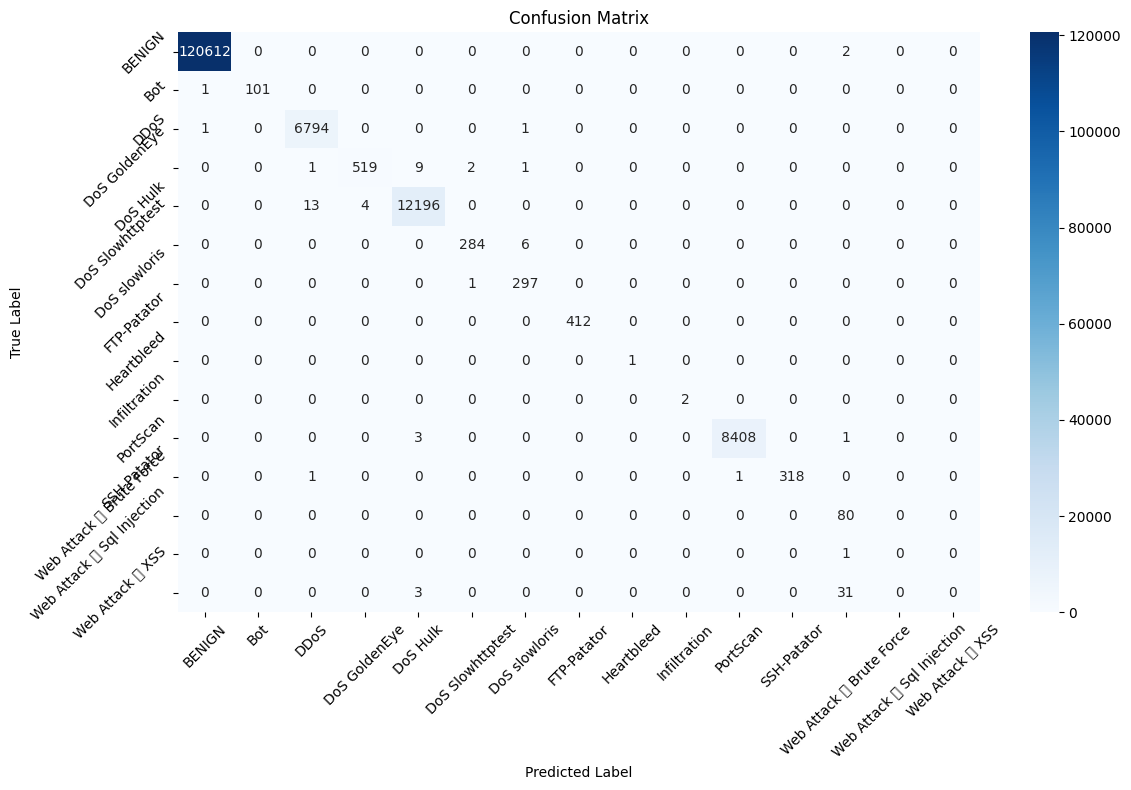


AUC Score (macro-average):
AUC Score: 1.0000


'# Optional: ROC curves for top 3 most frequent classes\ntop_classes_idx = pd.Series(y_test).value_counts().index[:3]\nplt.figure(figsize=(10, 6))\nfor class_idx in top_classes_idx:\n    fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_prob[:, class_idx])\n    plt.plot(fpr, tpr, label=f"Class {le.inverse_transform([class_idx])[0]}")\nplt.plot([0, 1], [0, 1], \'k--\', linewidth=1)\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\nplt.title("ROC Curve (Top 3 Classes)")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()'

In [3]:
import os
import pandas as pd
import numpy as np
import zipfile
import glob
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 0: Strip leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# Step 1: Create Payload column if it doesn't exist
def make_payload(row):
    flags = []
    if row['SYN Flag Count'] > 0: flags.append("SYN")
    if row['ACK Flag Count'] > 0: flags.append("ACK")
    if row['PSH Flag Count'] > 0: flags.append("PSH")

    return f"SRC={row['Source IP']} SPORT={row['Source Port']} " \
           f"DST={row['Destination IP']} DPORT={row['Destination Port']} " \
           f"PROTO={row['Protocol']} FLAGS={','.join(flags)} " \
           f"DURATION={row['Flow Duration']} PACKETS={row['Total Fwd Packets']} " \
           f"LEN={row['Total Length of Fwd Packets']}"

if 'Payload' not in df.columns:
    print("Generating artificial Payload column...")
    df['Payload'] = df.apply(make_payload, axis=1)

# === Step 1: Encode classes ===
print("Step 1: Encode attack labels into integers")
le = LabelEncoder()
df['y_class'] = le.fit_transform(df['Label'])

# === Step 2: Extract features and payload ===
print("Step 2: Extract features and payload")
text_col = 'Payload'
features = df.drop(columns=['Label', 'Payload', 'y_class'], errors='ignore').select_dtypes(include=[np.number])
text_data = df[text_col].astype(str).fillna("")

# === Step 3: Train-test split ===
print("Step 3: Train-test split")
X_tab_train, X_tab_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    features, text_data, df['y_class'], test_size=0.2, stratify=df['y_class'], random_state=42)

# === Step 4: Text vectorization ===
print("Step 4: Text vectorization layer")
vectorizer = layers.TextVectorization(output_mode="tf_idf", max_tokens=2000)
vectorizer.adapt(X_txt_train.values)

# === Step 5: Build model ===
print("Step 5: Building multimodal model")
input_tabular = layers.Input(shape=(X_tab_train.shape[1],), name="tabular_input")
x1 = layers.BatchNormalization()(input_tabular)
x1 = layers.Dense(128, activation="relu")(x1)
x1 = layers.Dropout(0.3)(x1)

input_text = layers.Input(shape=(1,), dtype=tf.string, name="text_input")
x2 = vectorizer(input_text)
x2 = layers.Dense(128, activation="relu")(x2)
x2 = layers.Dropout(0.3)(x2)

x = layers.concatenate([x1, x2])
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(len(le.classes_), activation="softmax")(x)

model = models.Model(inputs=[input_tabular, input_text], outputs=output)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])



# === Step 6: Train ===
print("Step 6: Training")
# Ensure tabular input is float32 and has no NaNs
X_tab_train = X_tab_train.astype("float32").fillna(0)
X_tab_test = X_tab_test.astype("float32").fillna(0)

X_txt_train = tf.convert_to_tensor(X_txt_train.tolist())
X_txt_test = tf.convert_to_tensor(X_txt_test.tolist())


history = model.fit(
    {"tabular_input": X_tab_train, "text_input": X_txt_train},
    y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=256
)



Step 7: Evaluation

Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    120614
                       Bot       1.00      0.99      1.00       102
                      DDoS       1.00      1.00      1.00      6796
             DoS GoldenEye       0.99      0.98      0.98       532
                  DoS Hulk       1.00      1.00      1.00     12213
          DoS Slowhttptest       0.99      0.98      0.98       290
             DoS slowloris       0.97      1.00      0.99       298
               FTP-Patator       1.00      1.00      1.00       412
                Heartbleed       1.00      1.00      1.00         1
              Infiltration       1.00      1.00      1.00         2
                  PortScan       1.00      1.00      1.00      8412
               SSH-Patator       1.00      0.99      1.00       320
  Web Attack  Brute Force       0.70      1.00      0.82        80
Web 

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


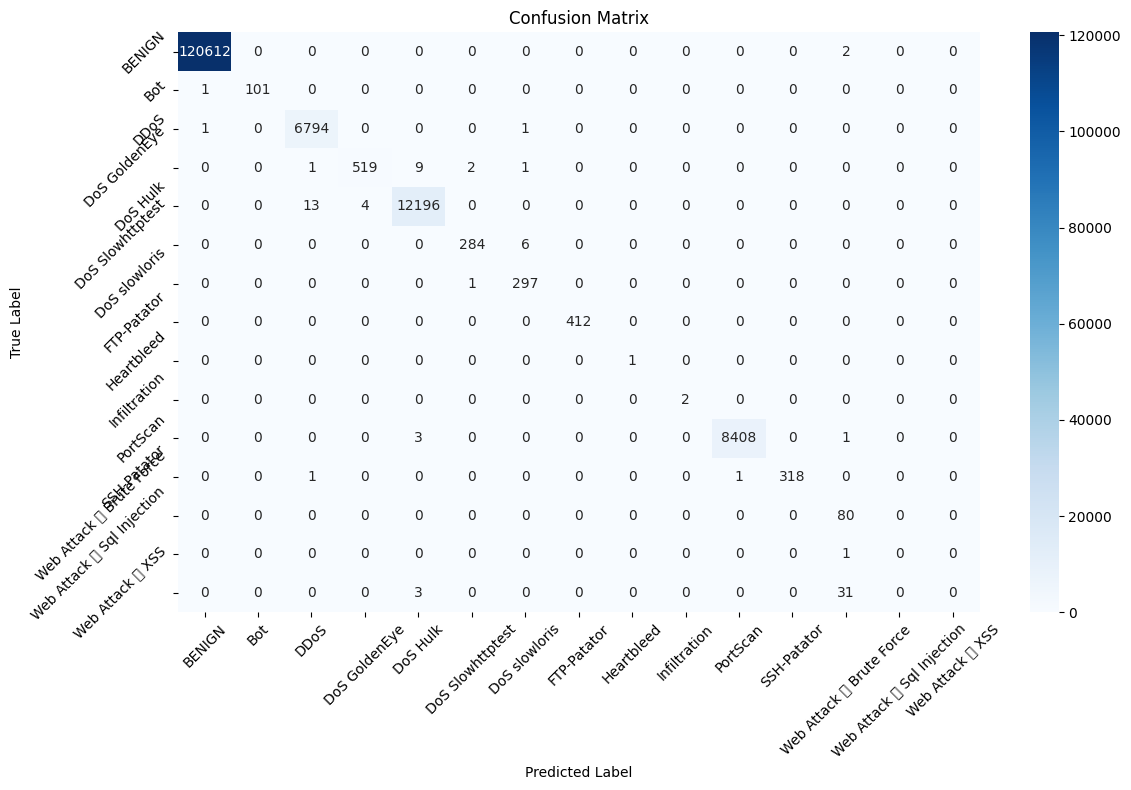


AUC Score (macro-average):
AUC Score: 1.0000


In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'


print("Step 7: Evaluation")

# Predict class probabilities and class labels
y_prob = model.predict({"tabular_input": X_tab_test, "text_input": X_txt_test}, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Handle only the labels that actually appear in y_test
labels_in_test = unique_labels(y_test, y_pred)
target_names_subset = le.inverse_transform(labels_in_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=labels_in_test, target_names=target_names_subset, zero_division=0))


# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=labels_in_test)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names_subset,
            yticklabels=target_names_subset)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# AUC (One-vs-Rest strategy)
print("\nAUC Score (macro-average):")
# Binarize labels for ROC AUC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
auc_score = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")



### **Interpretation of Model Results**

#### **What Indicates That the Results Are Reasonable**

- **High accuracy and low loss** across epochs suggest that the model is effectively learning patterns from the data.
- **Perfect AUC score (1.0000)** may be valid if the classes are clearly separable (e.g., BENIGN vs DDoS).
- **Large sample size in dominant classes** (such as BENIGN or DoS Hulk) supports reliable learning for those classes.

#### **However: Signs of Common Issues**

**Overfitting:**
- Training and validation performance are both nearly perfect, which may indicate the model is memorizing rather than generalizing.
- Excellent performance on large classes but **failure to detect rare classes** suggests the model ignores minority patterns.

**Failure to Detect Rare Classes:**
- Precision and recall are **undefined or zero** for classes like `Heartbleed` or `Web Attack XSS`.
- Warnings from classification metrics highlight that **no predictions were made** for certain labels.

#### **What Can Be Done to Improve and Validate the Model**

1. **Remove extremely rare classes** (e.g., those with fewer than 3 samples) to reduce noise.
2. **Apply oversampling** (e.g., SMOTE or RandomOverSampler) to balance the class distribution.
3. **Use weighted loss or focal loss** to penalize the model more when it misclassifies minority classes.
4. **Add dropout or L2 regularization** to prevent overfitting.
5. **Evaluate per-class metrics** such as precision, recall, and F1-score to understand performance on each class.
6. **Use stratified k-fold cross-validation** to ensure robust performance evaluation.
7. **Inspect misclassified samples** to gain insights into failure points.
8. **Train separate binary classifiers** for rare but important attack types.



# Train on dominant classes -  
    "BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest",
    "DoS slowloris", "Infiltration",
    "PortScan", "SSH-Patator"

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models

# === Step 0: Load and clean ===
print("Step 0: Cleaning column names...")
df.columns = df.columns.str.strip()

# === Step 1: Filter only relevant classes ===
print("Step 1: Filtering dataset to keep only selected classes...")
allowed_labels = [
    "BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest",
    "DoS slowloris", "FTP-Patator","PortScan", "SSH-Patator"
]
df = df[df['Label'].isin(allowed_labels)].copy()
print("Filtered dataset shape:", df.shape)

# === Step 2: Create Payload column ===
print("Step 2: Creating Payload text column...")
def make_payload(row):
    flags = []
    if row.get('SYN Flag Count', 0) > 0: flags.append("SYN")
    if row.get('ACK Flag Count', 0) > 0: flags.append("ACK")
    if row.get('PSH Flag Count', 0) > 0: flags.append("PSH")

    return f"SRC={row['Source IP']} SPORT={row['Source Port']} " \
           f"DST={row['Destination IP']} DPORT={row['Destination Port']} " \
           f"PROTO={row['Protocol']} FLAGS={','.join(flags)} " \
           f"DURATION={row['Flow Duration']} PACKETS={row['Total Fwd Packets']} " \
           f"LEN={row['Total Length of Fwd Packets']}"

df['Payload'] = df.apply(make_payload, axis=1)

# === Step 3: Encode labels ===
print("Step 3: Encoding class labels...")
le = LabelEncoder()
df['y_class'] = le.fit_transform(df['Label'])

# === Step 4: Extract features and text ===
print("Step 4: Extracting tabular and text features...")
text_col = 'Payload'
features = df.drop(columns=['Label', 'Payload', 'y_class'], errors='ignore').select_dtypes(include=[np.number])
text_data = df[text_col].astype(str).fillna("")

# === Step 5: Train-test split ===
print("Step 5: Splitting data into train and test sets...")
X_tab_train, X_tab_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    features, text_data, df['y_class'], test_size=0.2, stratify=df['y_class'], random_state=42)

# === Step 6: Text vectorization ===
print("Step 6: Adapting text vectorization layer...")
vectorizer = layers.TextVectorization(output_mode="tf_idf", max_tokens=2000)
vectorizer.adapt(X_txt_train.values)

# === Step 7: Build model ===
print("Step 7: Building multimodal model...")
input_tabular = layers.Input(shape=(X_tab_train.shape[1],), name="tabular_input")
x1 = layers.BatchNormalization()(input_tabular)
x1 = layers.Dense(128, activation="relu")(x1)
x1 = layers.Dropout(0.3)(x1)

input_text = layers.Input(shape=(1,), dtype=tf.string, name="text_input")
x2 = vectorizer(input_text)
x2 = layers.Dense(128, activation="relu")(x2)
x2 = layers.Dropout(0.3)(x2)

x = layers.concatenate([x1, x2])
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(len(le.classes_), activation="softmax")(x)

model = models.Model(inputs=[input_tabular, input_text], outputs=output)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# === Step 8: Train model ===
print("Step 8: Training model...")
X_tab_train = X_tab_train.astype("float32").fillna(0)
X_tab_test = X_tab_test.astype("float32").fillna(0)

X_txt_train = tf.convert_to_tensor(X_txt_train.tolist())
X_txt_test = tf.convert_to_tensor(X_txt_test.tolist())

history = model.fit(
    {"tabular_input": X_tab_train, "text_input": X_txt_train},
    y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=256
)

# === Step 9: Evaluate ===
print("Step 9: Evaluating model on test set...")
y_pred = np.argmax(model.predict({"tabular_input": X_tab_test, "text_input": X_txt_test}), axis=1)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Step 0: Cleaning column names...
Step 1: Filtering dataset to keep only selected classes...
Filtered dataset shape: (750059, 88)
Step 2: Creating Payload text column...
Step 3: Encoding class labels...
Step 4: Extracting tabular and text features...
Step 5: Splitting data into train and test sets...
Step 6: Adapting text vectorization layer...
Step 7: Building multimodal model...
Step 8: Training model...
Epoch 1/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9746 - loss: 0.0932 - val_accuracy: 0.9993 - val_loss: 0.0185
Epoch 2/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 3/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9990 - val_loss: 0.0023
Epoch 4/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9997 - loss: 9.7164e-04 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 5/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0

Step 10: Calculating AUC scores and plotting ROC curves...
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Macro AUC: 1.0000
Weighted AUC: 1.0000


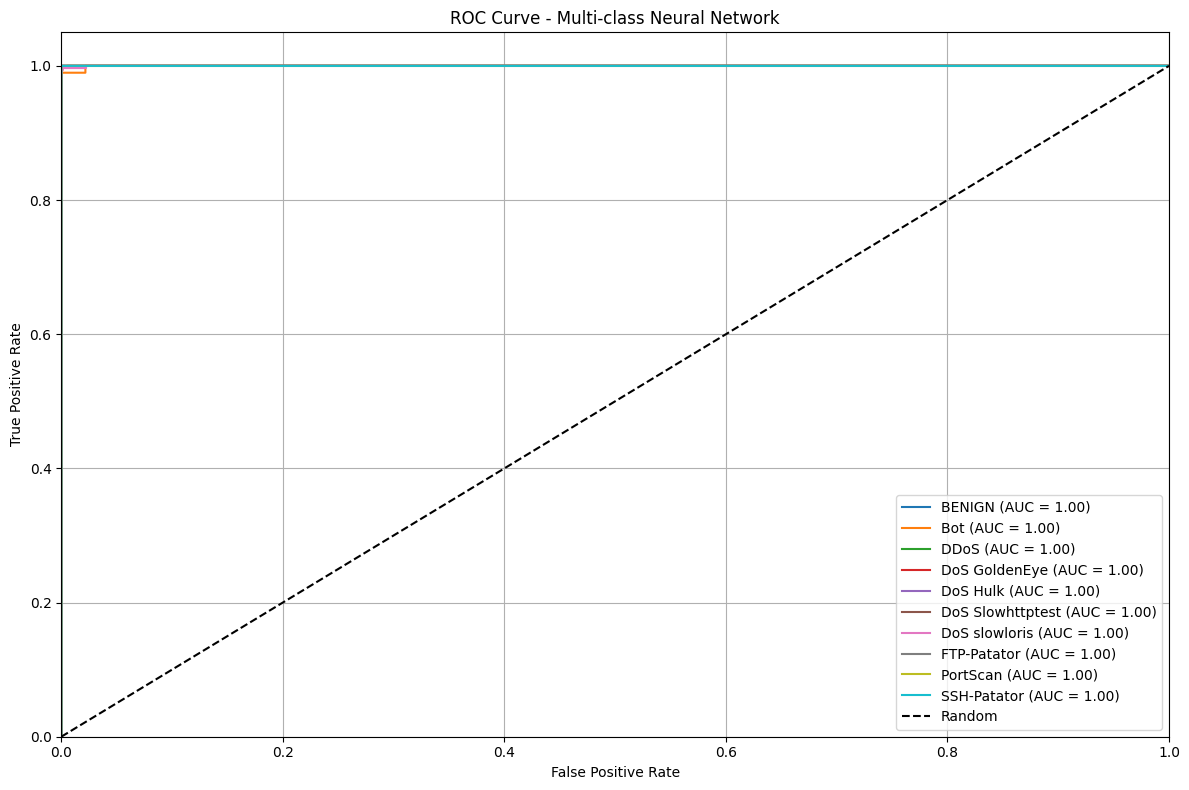

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# === Step 10: AUC and ROC Curve ===
print("Step 10: Calculating AUC scores and plotting ROC curves...")

# Binarize true labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(len(le.classes_)))
y_proba = model.predict({"tabular_input": X_tab_test, "text_input": X_txt_test})

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average and weighted-average AUC
macro_auc = roc_auc_score(y_test_binarized, y_proba, average='macro')
weighted_auc = roc_auc_score(y_test_binarized, y_proba, average='weighted')

print(f"Macro AUC: {macro_auc:.4f}")
print(f"Weighted AUC: {weighted_auc:.4f}")

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class Neural Network")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
